In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast,json


In [3]:
from matplotlib.offsetbox import bbox_artist


def load_df(fname):
    df = pd.read_csv(fname)
    
    df["SN Undiagnosed"] = df["SN Untreated chronic"].values + df["SN Untreated acute"].values
    df["CN Undiagnosed"] = df["CN Untreated chronic"].values + df["CN Untreated acute"].values
    
    df["SN sample size"] = [len(ast.literal_eval(x)) - len(ast.literal_eval(y)) for x,y in zip(df["SN sampled"],df["SN seed"])] #df.apply(lambda x: x["SN sampled"].len())
    df["CN sample size"] = [len(ast.literal_eval(x)) - len(ast.literal_eval(y)) for x,y in zip(df["CN sampled"],df["CN seed"])]
    
    return df


def boxplots(fname,savename1,savename2,plot1ylim=(0,40)):
    df = load_df(fname)
    
    # Plot 1
    df.boxplot(column=["SN GN count","CN GN count","SN TN count","CN TN count"],positions=[1,2,3,4],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # df.boxplot(column=["SN GN count","SN TN count"],positions=[1,3],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # box2 = df.boxplot(column=["CN GN count","CN TN count"],return_type="dict",positions=[2,4],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    #     plt.setp(box2[item], color="darkred")
    plt.ylim(plot1ylim)
    plt.ylabel("Number of pairs")
    try:
        plt.savefig(savename1,bbox_inches="tight", dpi=600)
    except:
        plt.savefig(savename1,bbox_inches="tight")
    plt.show()

    # Plot 2
    df.boxplot(column=["SN sample size","SN HIV+","SN Out-of-care","SN Undiagnosed","CN sample size","CN HIV+","CN Out-of-care","CN Undiagnosed"],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # df.boxplot(column=["SN HIV+"],positions=[1],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # box2 = df.boxplot(column=["CN HIV+"],return_type="dict",positions=[2],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    #     plt.setp(box2[item], color="darkred")
    plt.xticks(ticks=[1,2,3,4,5,6,7,8], labels=["SN size","SN HIV+","SN OOC","SN UD","CN size","CN HIV+","CN OOC","CN UD"])
    plt.ylim([0,625])
    try:
        plt.savefig(savename2,bbox_inches="tight", dpi=600)
    except:
        plt.savefig(savename2,bbox_inches="tight")
    plt.ylabel("Number of individuals")
    plt.show()

    
def percentages(fname):
    df = load_df(fname)
    SNdenom = np.median(df["SN sample size"].values)
    CNdenom = np.median(df["CN sample size"].values)
    SNhiv = np.median(df["SN HIV+"].values)
    CNhiv = np.median(df["CN HIV+"].values)
    SNooc = np.median(df["SN Out-of-care"].values)
    CNooc = np.median(df["CN Out-of-care"].values)
    SNud = np.median(df["SN Undiagnosed"].values)
    CNud = np.median(df["CN Undiagnosed"].values)
    props = {"SN sample size" : SNdenom, "CN sample size" : CNdenom, "SN HIV+" : SNhiv/SNdenom,"SN OOC" : SNooc/SNdenom,"SN UD" : SNud/SNdenom,"CN HIV+" : CNhiv/CNdenom,"CN OOC" : CNooc/CNdenom,"CN UD" : CNud/CNdenom}
    return props
    


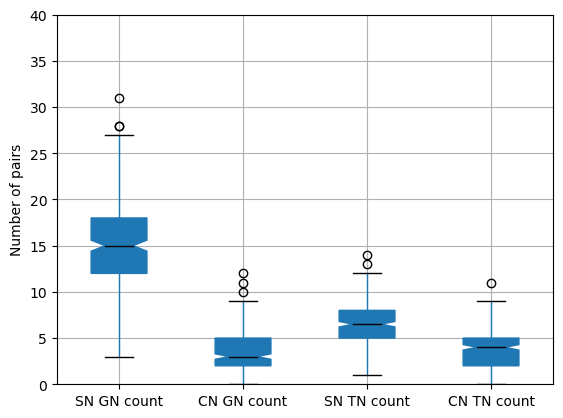

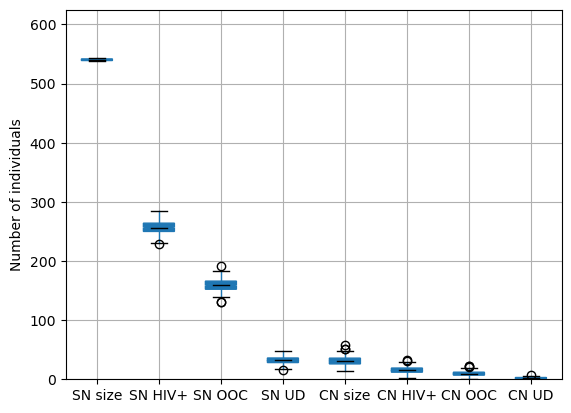

{'SN sample size': 540.0, 'CN sample size': 31.0, 'SN HIV+': 0.475, 'SN OOC': 0.29444444444444445, 'SN UD': 0.05925925925925926, 'CN HIV+': 0.4838709677419355, 'CN OOC': 0.2903225806451613, 'CN UD': 0.06451612903225806}


In [4]:
fname = "results_trimmed_end/JOB758832/all_summaries_20221031.csv"
boxplots(fname,"results_trimmed_end/JOB758832/gn_tn_edges_20221031_end.jpg","results_trimmed_end/JOB758832/compartments_20221031_end.jpg")
print(percentages(fname))

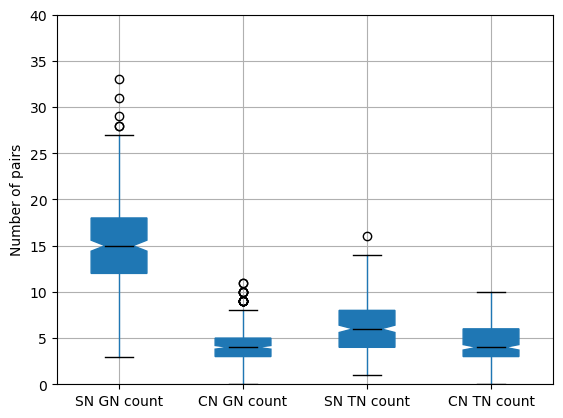

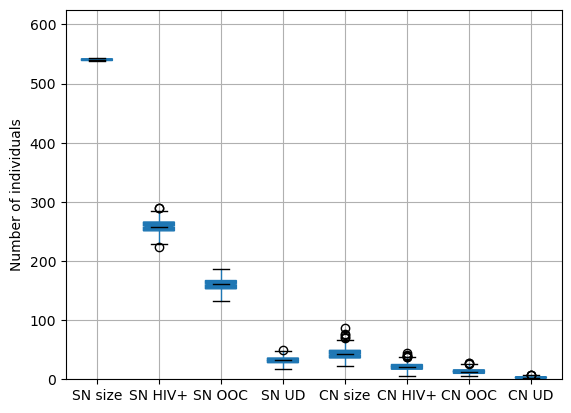

{'SN sample size': 540.0, 'CN sample size': 42.0, 'SN HIV+': 0.4777777777777778, 'SN OOC': 0.29814814814814816, 'SN UD': 0.05925925925925926, 'CN HIV+': 0.5, 'CN OOC': 0.30952380952380953, 'CN UD': 0.07142857142857142}


In [5]:
fname = "results_trimmed_end/JOB758832_RDS_contact/all_summaries_20221031contact.csv"
boxplots(fname,"results_trimmed_end/JOB758832_RDS_contact/gn_tn_edges_20221031_end_contact.jpg","results_trimmed_end/JOB758832_RDS_contact/compartments_20221031_end_contact.jpg")
print(percentages(fname))

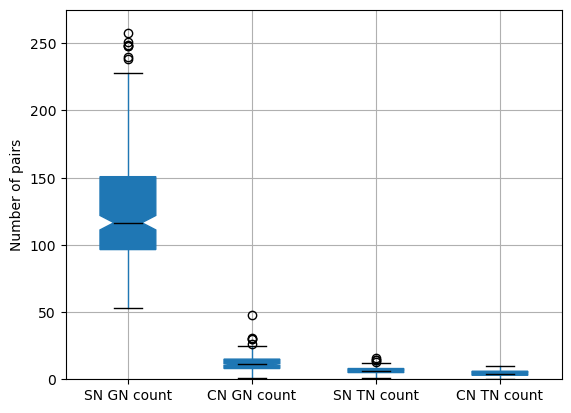

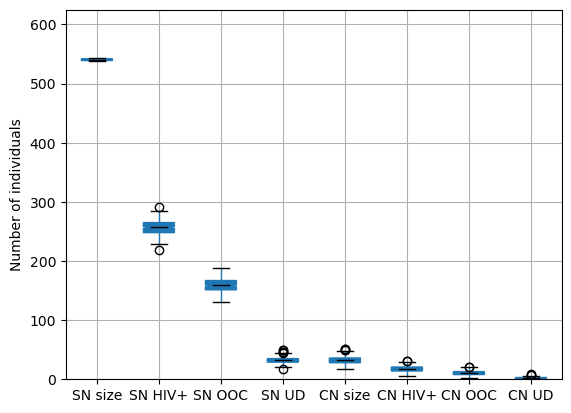

{'SN sample size': 540.0, 'CN sample size': 32.0, 'SN HIV+': 0.4759259259259259, 'SN OOC': 0.29444444444444445, 'SN UD': 0.05925925925925926, 'CN HIV+': 0.53125, 'CN OOC': 0.3125, 'CN UD': 0.0625}


In [6]:
fname = "results_trimmed_infection/JOB784278/all_summaries_20221118_infection.csv"
boxplots(fname,"results_trimmed_infection/JOB784278/gn_tn_edges_20221118_infection.jpg","results_trimmed_infection/JOB784278/compartments_20221118_infection.jpg",plot1ylim=[0,275])
print(percentages(fname))

In [7]:
# fname = "results_trimmed_end/JOB758832_social_tracing/all_summaries_20221102_social.csv"
# boxplots(fname)
# print(percentages(fname))